In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
# %matplotlib inline

from plotting import *
from molecule_rot import MoleculeRot

In [2]:
home = os.path.abspath('/mnt/research/RotateDiheds/data')
master_dir = os.path.join(home,'masters/')
plot_dir = os.path.join(home, 'plots/')

all_molecules = make_all_mol_list(master_dir)
print("Done making all_molecules list.")  

mol = MoleculeRot('mols_66_5_17_n-n-cOC-cOC', master_dir)
mol

Done making all_molecules list.


In [3]:
mol = all_molecules[7]
len(all_molecules)

272

In [4]:
def boltzman_dist(x, A=1):
    return A*np.exp(-x/(298*8.314))
def get_probability(energy_df):
    probability_df = pd.DataFrame()
    if isinstance(energy_df, pd.DataFrame) and len(energy_df.index) > 1:
        probability_df['probability'] = energy_df.energy.apply(lambda x: boltzman_dist(x))
        sum_prob = probability_df.probability.sum()
        probability_df.probability = probability_df.probability.apply(lambda x: x/sum_prob)
        return probability_df
def planarity_func(angle, prob):
    angle_rad = angle * np.pi / 180
    return prob * np.cos(angle_rad)**2
def planarity(probability_df):
    try:
        probability_df['angle'] = probability_df.index
        indiv_planarity = probability_df.apply(lambda x: planarity_func(x.angle, x.probability), axis=1)
        planarity = indiv_planarity.sum()
        probability_df.drop(['angle'], axis=1, inplace=True)
        return planarity
    except: 
        return None
def sterio_norm_eng(energy_df, steriochem):
    norm_energy = pd.DataFrame()
    if isinstance(energy_df, pd.DataFrame) and len(energy_df.index) > 1:
        if steriochem < 0:
            norm_energy['sterio_norm_eng'] = energy_df.energy.values[::-1].astype(np.float64)
            norm_energy.index = pd.Float64Index(energy_df.index)
        else: 
            norm_energy['sterio_norm_eng'] = energy_df.energy
        return norm_energy
    else: 
        return np.nan
def highest_e_surface(molecule, data):
    mols = data.loc[data.molecule == molecule, 'barrier_height'].idxmax()
    return str(data.iloc[mols].unit_num)

In [5]:
data = pd.DataFrame()
for i, mol in enumerate(all_molecules):
    try:
        energy = pd.DataFrame(mol.norm_energy_dict.values(),index=mol.norm_energy_dict.keys(), columns=['energy'])
    except AttributeError: 
        energy = None
    try: 
        homo_lumo_init = pd.DataFrame([mol.homo_dict, mol.lumo_dict], index=['lumo_energy','homo_energy'])
        homo_lumo = homo_lumo_init.T
    except AttributeError: 
        homo_lumo = None
    try:
        cent_bond_length = pd.DataFrame(mol.central_bond_length_dict.values(),index=mol.central_bond_length_dict.keys(), columns=['bond_length'])
    except AttributeError: 
        cent_bond_length = None
    mol_data = {'name': mol.name, 
                'ring_num': mol.ring_num,
                'unit_num': mol.unit_num,
                'polymer_num': mol.polymer_num,
                'chromophore': str(mol.chromophore),
                'substituents': (mol.substituents).upper(),
                'side_chains': mol.side_chains,
                'tuned_omega': mol.tuned_omega,
                'smiles': mol.smiles,
                'central_bond_lengths': cent_bond_length,
                'energy': energy,
                'homo_lumo': homo_lumo, 
                'min_e_angle': mol.unconst_angle,
                'steriochem': mol.anti_syn, 
                'barrier_height': mol.max_e_norm
               }
    data = data.append(mol_data, ignore_index=True) 

data.fillna(value=np.nan, inplace=True)
data['side_chains_str'] = data.apply(lambda x: str(x.side_chains), axis=1)
data['molecule'] = data.apply(lambda x: '{:.0f}_{:.0f}'.format(x['ring_num'],x['polymer_num']), axis=1)
# data['tuned_omega'] = data.apply(lambda x: "0."+ str(x.tuned_omega)[1:] if pd.notna(x.tuned_omega) else np.nan, axis=1)
data['adjusted_min_e_angle'] = data.apply(lambda x: abs(90 - x.min_e_angle) if pd.notna(x.min_e_angle) else np.nan, axis=1)
data['molecule_type'] = data.chromophore + data.side_chains_str
data['inv_tuned_omega'] = data.tuned_omega.apply(lambda x: 1/x if pd.notna(x) else np.nan,)
data['probability'] = data.apply(lambda x: get_probability(x.energy) if x.energy is not np.nan else np.nan, axis=1)
data['sterio_norm_energy'] = data.apply(lambda x: sterio_norm_eng(x.energy, x.steriochem), axis=1)
data['planarity'] = data.apply(lambda x: planarity(x.probability) if x.probability is not np.nan else np.nan, axis=1)
data['highest_e_unit'] = data.apply(lambda x: highest_e_surface(x.molecule, data), axis=1)
data.head()

,barrier_height,central_bond_lengths,chromophore,energy,homo_lumo,min_e_angle,name,polymer_num,ring_num,side_chains,...,unit_num,side_chains_str,molecule,adjusted_min_e_angle,molecule_type,inv_tuned_omega,probability,sterio_norm_energy,planarity,highest_e_unit
0,3.790822,bond_length 0.0 1.342520 10.0 ...,bithiophene,energy 0.0 1.423089 10.0 1.40451...,lumo_energy homo_energy 0.0 -9.56...,179.999942,mols_55_1_00_C-C,0.0,55.0,(),...,1.0,(),55_0,89.999942,bithiophene(),3.188427,probability 0.0 0.052640 10.0 ...,sterio_norm_eng 0.0 1.423089 ...,0.526474,1.0
1,2.615687,bond_length 0.0 1.375265 10.0 ...,bithiophene,energy 0.0 0.191329 10.0 0.20460...,lumo_energy homo_energy 0.0 -9.31...,179.999978,mols_55_1_01_C-CF,1.0,55.0,"(F,)",...,1.0,"('F',)",55_1,89.999978,"bithiophene('F',)",12.915568,probability 0.0 0.052651 10.0 ...,sterio_norm_eng 0.0 0.191329 ...,0.526446,7.0
2,5.642083,bond_length 0.0 1.419547 10.0 ...,thienyl_thiazole,energy 0.0 0.941336 10.0 1.06325...,lumo_energy homo_energy 0.0 -9.46...,179.999911,mols_55_1_02_C-N,2.0,55.0,(),...,1.0,(),55_2,89.999911,thienyl_thiazole(),3.131526,probability 0.0 0.052668 10.0 ...,sterio_norm_eng 0.0 0.941336 ...,0.526586,3.0
3,5.243906,bond_length 0.0 1.291189 10.0 ...,bithiophene,energy 0.0 0.951972 10.0 1.10274...,lumo_energy homo_energy 0.0 -9.92...,179.999967,mols_55_1_03_C-COC,3.0,55.0,"(OCH3,)",...,1.0,"('OCH3',)",55_3,89.999967,"bithiophene('OCH3',)",3.270234,probability 0.0 0.052670 10.0 ...,sterio_norm_eng 0.0 0.951972 ...,0.526562,1.0
4,3.701768,bond_length 0.0 1.288862 10.0 ...,bithiophene,energy 0.0 3.701768 10.0 3.44320...,lumo_energy homo_energy 0.0 -10.84...,180.000000,mols_55_1_04_CF-CF,4.0,55.0,"(F, F)",...,1.0,"('F', 'F')",55_4,90.000000,"bithiophene('F', 'F')",4.527533,probability 0.0 0.052601 10.0 ...,sterio_norm_eng 0.0 3.701768 ...,0.526399,1.0


In [6]:
out_dir = os.path.join(plot_dir,'other/')
mols = data.loc[(data.chromophore == 'thiazolyl_pyrimidine')]
type(mols.iloc[2].sterio_norm_energy.index)


pandas.core.indexes.numeric.Float64Index

In [7]:
import seaborn as sns
omega_data = data[['unit_num', 'tuned_omega']]
omega_data.dropna(inplace=True)
# fig, ax = plt.subplots(1)
# sns.regplot(omega_data.unit_num, omega_data.tuned_omega)

/home/rebekah/miniconda3/envs/rotdiheds/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


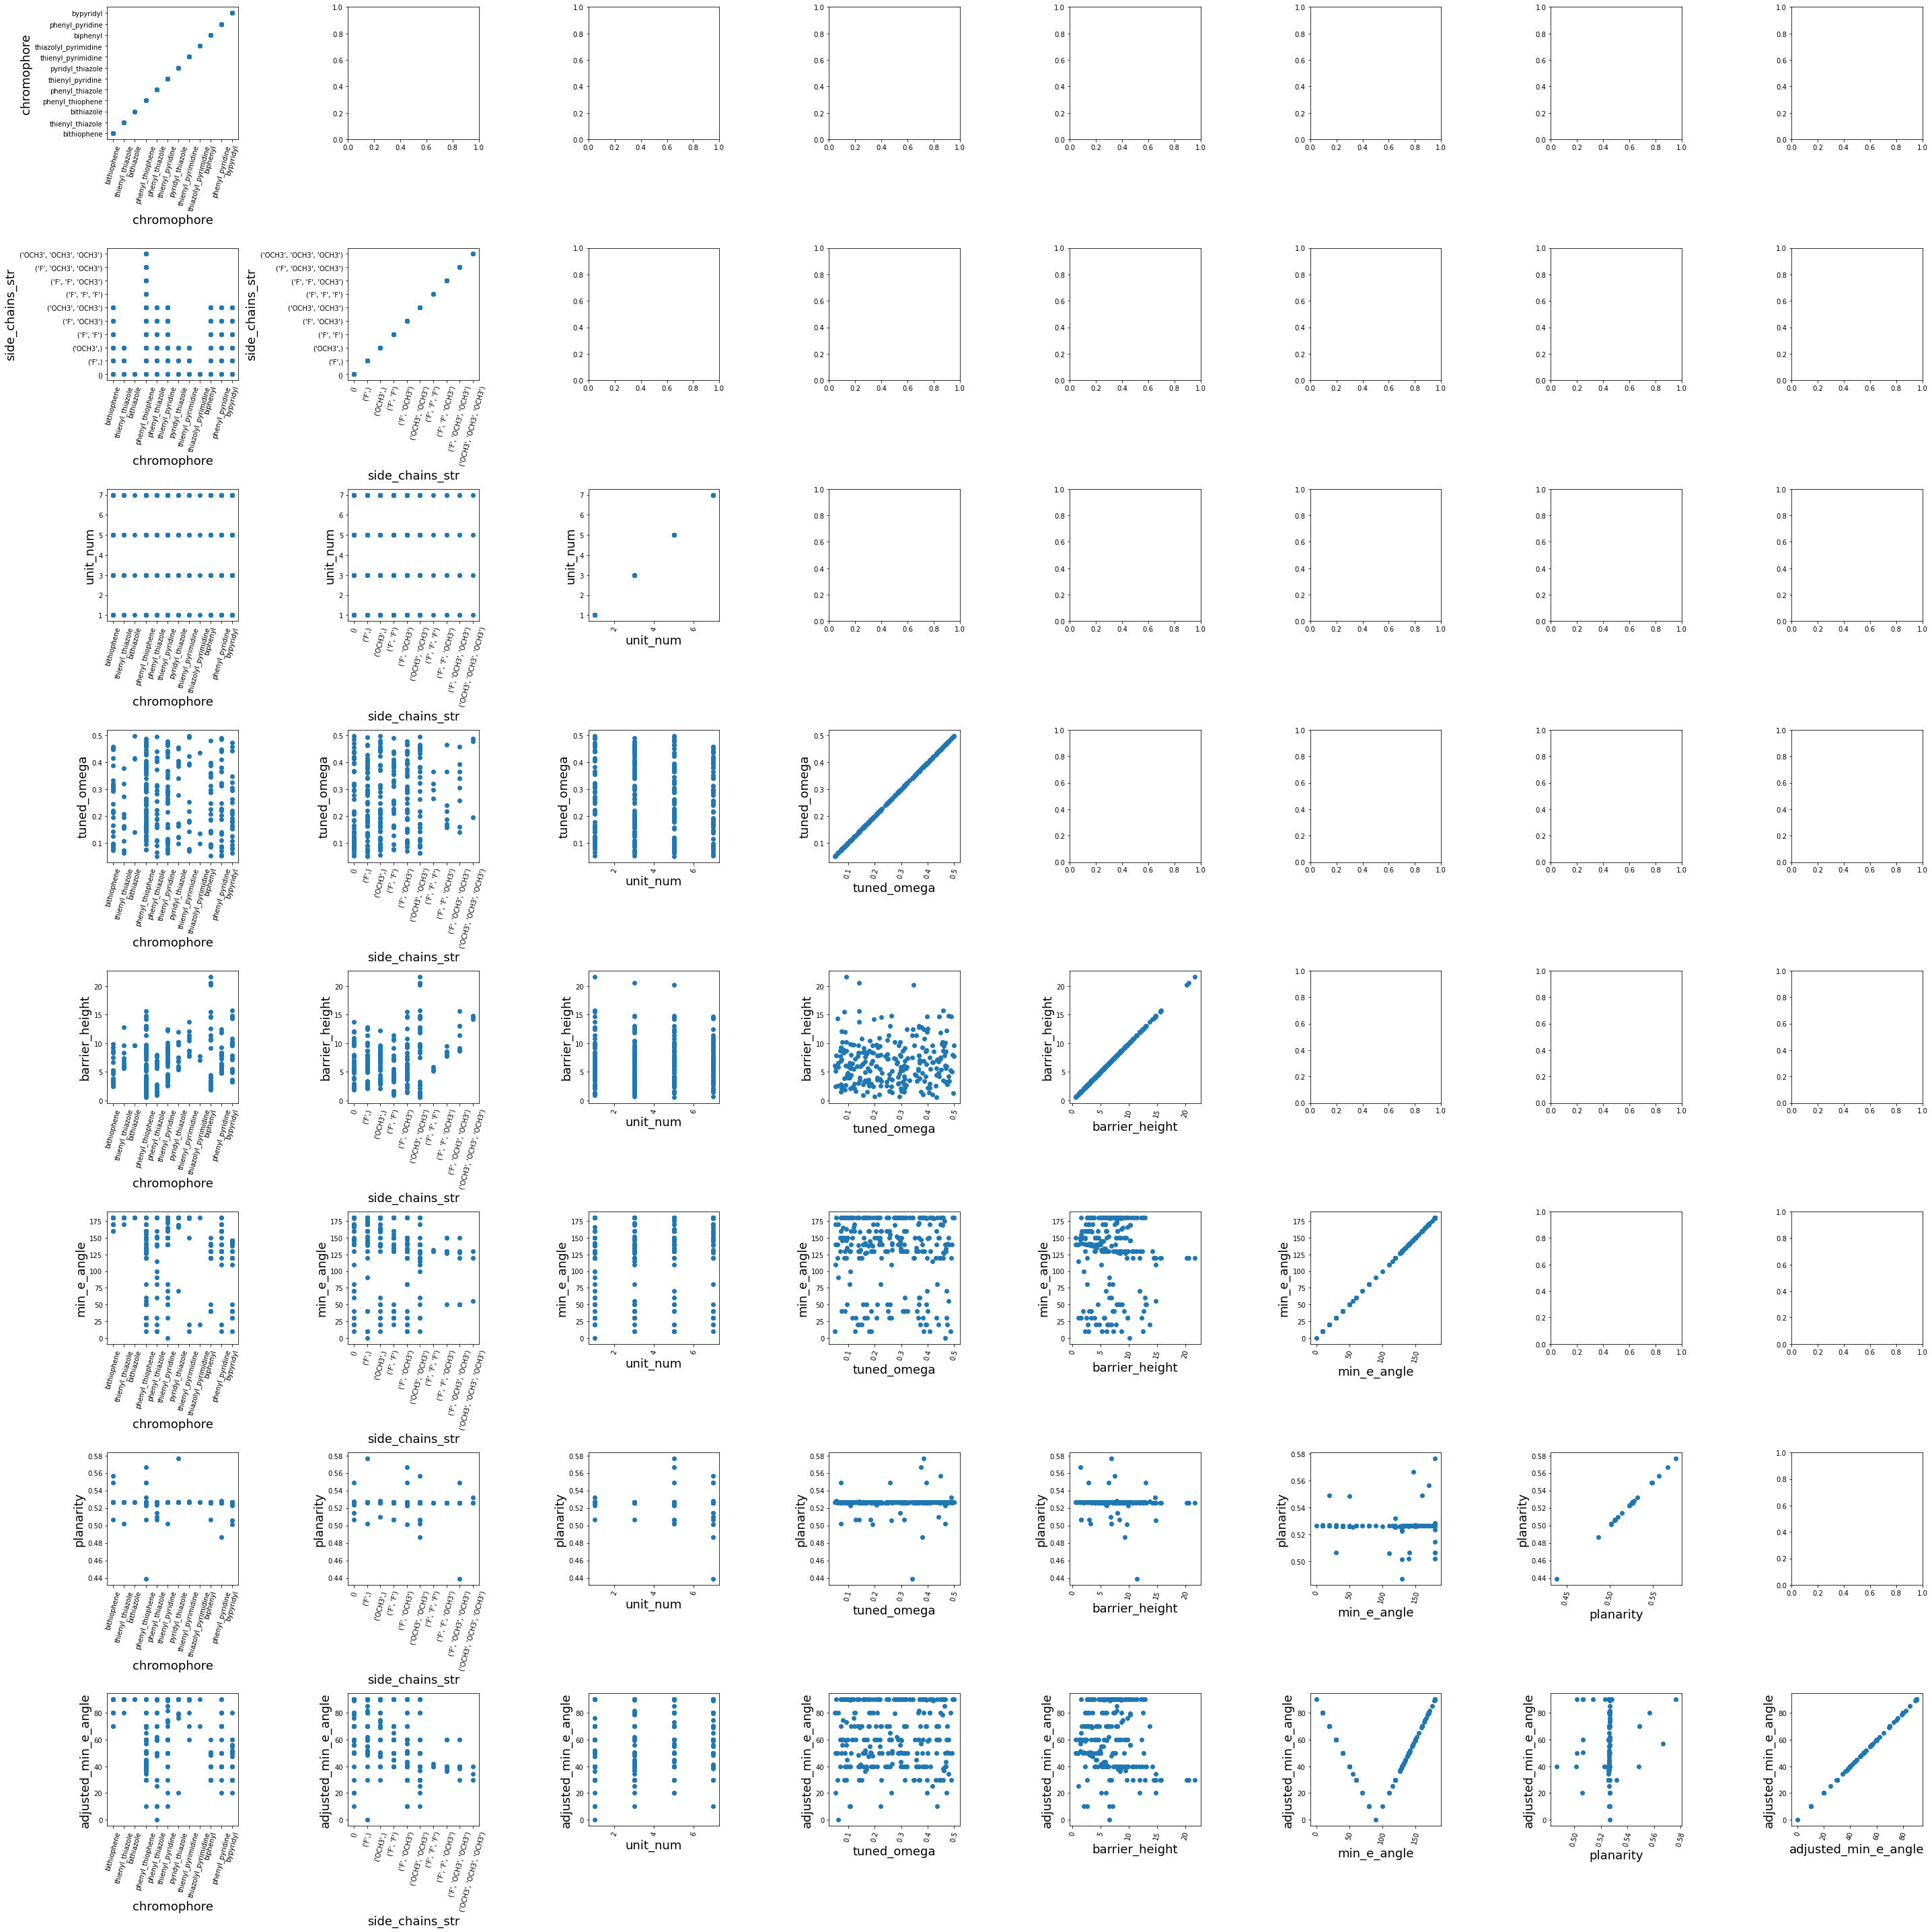

In [8]:
# Compare non-energy properties with scatter

comparing_columns = ['chromophore', 'side_chains_str', 'unit_num', 'tuned_omega', 'barrier_height', 
                     'min_e_angle', 'planarity', 'adjusted_min_e_angle']
num_properties = len(comparing_columns)
fig, axes = plt.subplots(num_properties, num_properties, figsize=(40,40))
for i in range(num_properties):
    for j in range(i,num_properties):
        ax = axes[j,i]
        try: 
            x, y = comparing_columns[i], comparing_columns[j]
            ax.scatter(data[x], data[y])
            ax.set_xlabel(x, fontsize=18)
            ax.set_ylabel(y, fontsize=18)
            ax.tick_params(axis='x', labelrotation=75)
        except: 
            pass
fig.patch.set_facecolor("w")
plt.tight_layout()
fig.savefig(out_dir + 'ALL.png', dpi=300, bbox_inches='tight')

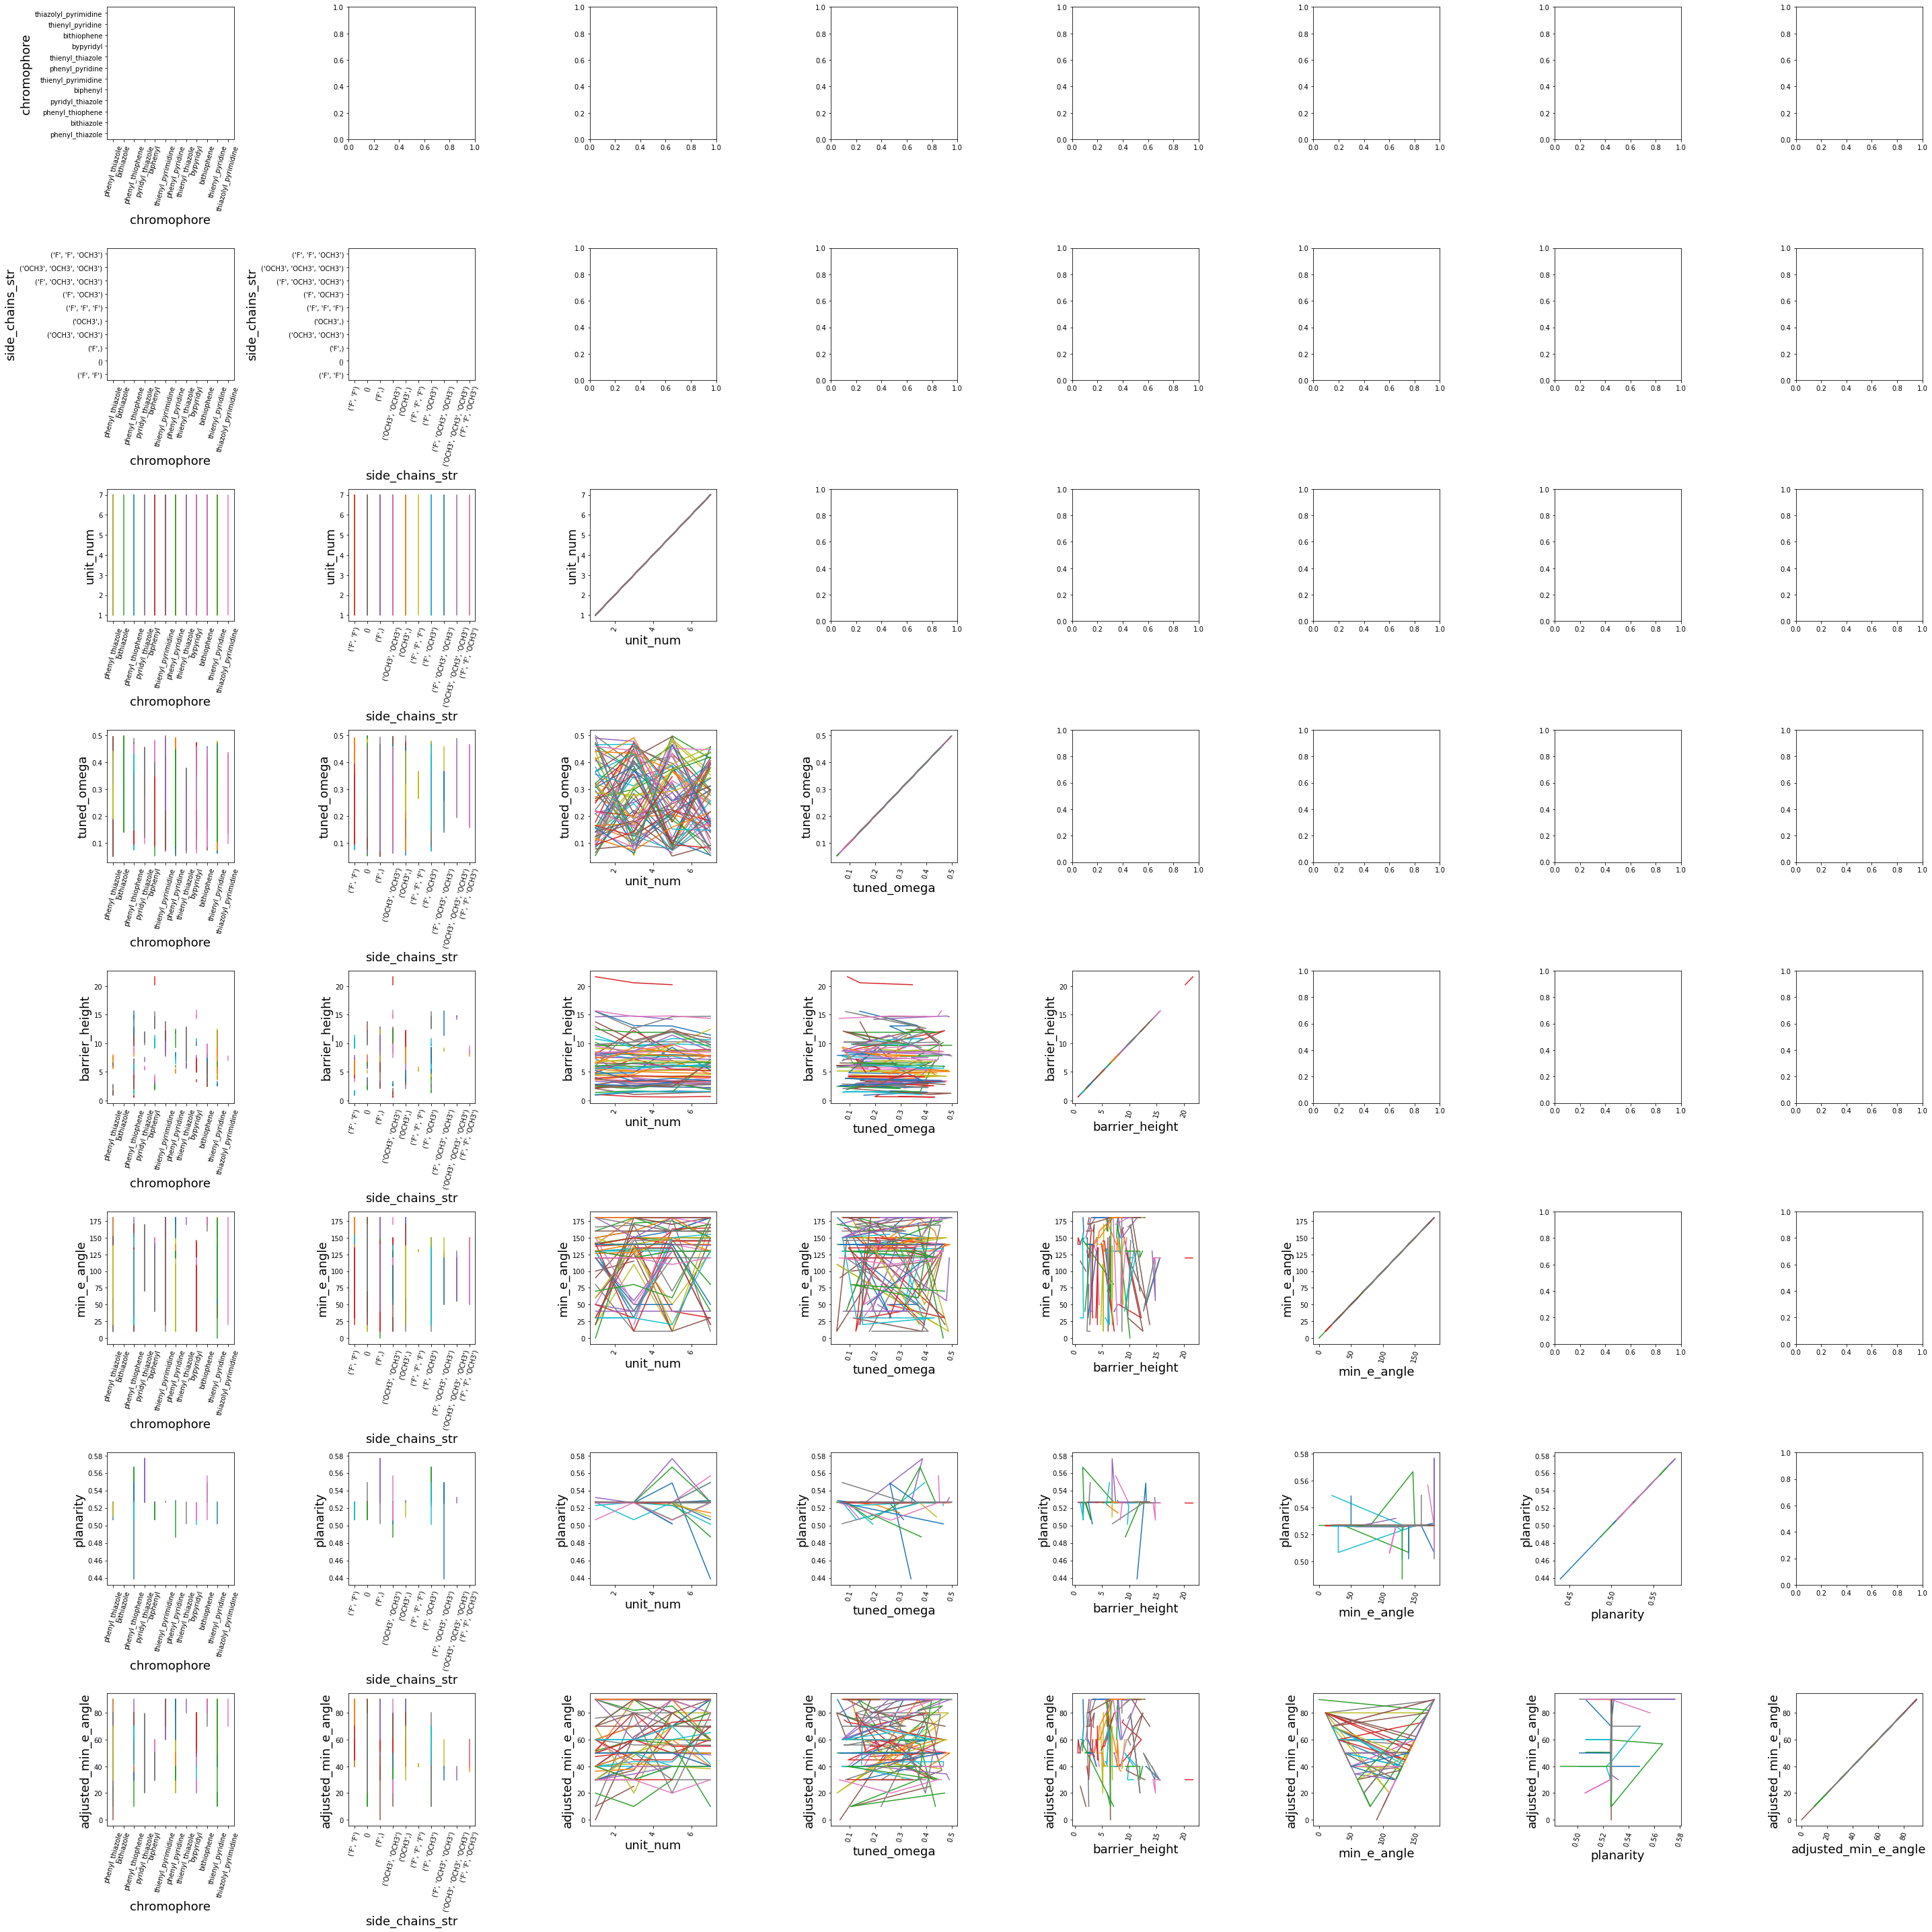

In [9]:
# Compare non-energy properties with plot 

comparing_columns = ['chromophore', 'side_chains_str', 'unit_num', 'tuned_omega', 'barrier_height', 
                     'min_e_angle', 'planarity', 'adjusted_min_e_angle']
molecules = set(data.molecule)

num_properties = len(comparing_columns)
fig, axes = plt.subplots(num_properties, num_properties, figsize=(40,40))
for i in range(num_properties):
    for j in range(i,num_properties):
        ax = axes[j,i]
        for mol in molecules:
            mols = data.loc[data.molecule == mol]
            mols = mols.rename(index=mols.name)
            x, y = comparing_columns[i], comparing_columns[j]
            ax.plot(mols[x], mols[y], label=mol)
            ax.set_xlabel(x, fontsize=18)
            ax.set_ylabel(y, fontsize=18)
            ax.tick_params(axis='x', labelrotation=75)
#             if i == 1: 1
#                 fig.legend(bbox_to_anchor=(1.07, 1))
        
fig.patch.set_facecolor("w")
plt.tight_layout()
fig.savefig(out_dir + 'ALL_mols.png', dpi=300, bbox_inches='tight')

In [8]:
def draw_chromophore(smiles, ax):
    rd_mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(rd_mol)
    mol_rd_image = Draw.MolToImage(rd_mol)
    mol_image = mpimg.pil_to_array(mol_rd_image)
    ax.add_artist(AnnotationBbox(OffsetImage(mol_image, zoom=0.4), (90, 18), frameon=False))
    
def make_group_plot(data, var_property, y_properties, out_dir, tag='', draw=False):
    properties = set(data[var_property])
    plot_len = int(np.ceil(len(properties)/4))
    fig, axes = plt.subplots(plot_len, 4, figsize=(15, 5*plot_len))

    color_dict = {1: 'grey', 3: 'c', 5: 'm', 7: 'y'}
    for i, prop in enumerate(properties): 
        ax = axes.item(i)
        y_property = y_properties[0]
        if len(y_properties) > 1:
            y_property2 = y_properties[1]
            ax2 = ax.twinx()
            mols = data.loc[(data[var_property] == prop) & (data[y_property].notnull()) & (data[y_property2].notnull())]
            plot_name = "{}-{}".format(y_property, y_property2)
        else: 
            y_property2 = None
            mols = data.loc[(data[var_property] == prop) & (data[y_property].notnull())]
            plot_name = y_property
        mols.rename(index=mols.name, inplace=True)
                
        ax.set_title(prop)
        for _, mol in mols.iterrows(): 
            ax.plot(mol[y_property], color=color_dict[mol.unit_num])
            if y_property2: 
                ax2.plot(mol[y_property2], color=color_dict[mol.unit_num], linestyle='dashed')
                if y_property2 == 'central_bond_lengths':
                    ax2.set_ylim(bottom=1.2, top=1.5)
            if y_property == ("sterio_norm_energy" or "energy") and mol.side_chains_str == "()" and var_property == "chromophore": 
                ax.plot(mol[y_property], color='k')
                if mol.unit_num == 1:
                    draw_chromophore(mol.smiles, ax)
            if draw and mol.unit_num == 1: 
                ax.set_ylim(top = 23)
                draw_chromophore(mol.smiles, ax)
                ax.set_title(mol.chromophore+mol.side_chains_str)
                
    title_plot_name = ' '.join(plot_name.split('_')).title()
    fig.text(0.5, -0.01, 'Dihedral Rotation Degrees', ha='center', fontsize=18)
    fig.text(-0.01, 0.5, title_plot_name + ' (kcal/mol)', va='center', rotation='vertical', fontsize=18)
    fig.text(0.3, 1.02, 'Number of Units: ', ha='center', fontsize=18)
    if tag != '': 
        title = "Change in {} with Dihedral Rotation by {} for {}".format(title_plot_name, var_property.capitalize(), tag.capitalize()) 
    else: 
        title = "Change in {} with Dihedral Rotation by {}".format(title_plot_name, var_property.capitalize())
    fig.text(0.5, 1.07, title, ha='center', fontsize=24)
    fig.patch.set_facecolor("w")
    markers = [Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
    fig.legend(markers, color_dict.keys(), numpoints=1, fontsize=18, bbox_to_anchor=(0.75, 1.05),ncol=len(color_dict.keys()))
    fig.tight_layout()
    fig.savefig(out_dir + '{}{}_{}.png'.format(tag, plot_name.upper(), var_property), dpi=300, bbox_inches='tight')
    plt.close()
    

In [9]:
def prop_plots(data, plot_prop, var_property, y_property):
    y_prop_name = '_'.join(y_property).lower()
    out_dir = os.path.join(plot_dir,'other/', "{}_{}/".format(plot_prop, y_prop_name))
    if not os.path.isdir(out_dir): os.mkdir(out_dir)
    plot_properties = set(data[plot_prop])
    for p in plot_properties: 
        sorted_data = data.loc[(data[plot_prop] == p)]
        make_group_plot(sorted_data, var_property, y_property, out_dir, tag=p, draw=True)

In [11]:
out_dir = os.path.join(plot_dir,'other/')
# var_properties = ['side_chains_str', 'chromophore', 'unit_num', 'molecule', 'steriochem']
# y_properties = [['homo_lumo'], ['sterio_norm_energy'], ['energy'], ['central_bond_lengths'], ['energy', 'probability'], ['sterio_norm_energy', 'central_bond_lengths']]
var_properties = ['molecule']
y_properties = [['sterio_norm_energy']]
for var_property in var_properties:
    for y_property in y_properties: 
        if var_property == 'molecule': 
            make_group_plot(data, var_property, y_property, out_dir)
        else: 
            make_group_plot(data, var_property, y_property, out_dir)

/home/rebekah/miniconda3/envs/rotdiheds/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/rebekah/miniconda3/envs/rotdiheds/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/rebekah/miniconda3/envs/rotdiheds/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

/home/rebekah/miniconda3/envs/rotdiheds/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/rebekah/miniconda3/envs/rotdiheds/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/rebekah/miniconda3/envs/rotdiheds/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [ ]:
var_property = 'molecule'

y_properties = [['sterio_norm_energy'], ['homo_lumo'], ['sterio_norm_energy', 'central_bond_lengths']]
plot_properties = ['chromophore', 'side_chains_str', 'highest_e_unit']
for plot_prop in plot_properties: 
    for y_property in y_properties: 
        print(plot_prop, y_property)
        prop_plots(data, plot_prop, var_property, y_property)

/home/rebekah/miniconda3/envs/rotdiheds/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


chromophore ['sterio_norm_energy']
chromophore ['homo_lumo']
chromophore ['sterio_norm_energy', 'central_bond_lengths']
side_chains_str ['sterio_norm_energy']
side_chains_str ['homo_lumo']
side_chains_str ['sterio_norm_energy', 'central_bond_lengths']
highest_e_unit ['sterio_norm_energy']
highest_e_unit ['homo_lumo']


In [ ]:
out_dir = os.path.join(plot_dir,'other/')
propert = 'side_chains_str'
properties = set(data[propert])

plot_len = int(np.ceil(len(properties)/4))
fig, axes = plt.subplots(plot_len, 4, figsize=(15,10), sharey=True, sharex=True)

for i, prop in enumerate(properties): 
    mols_prop = data.loc[(data[propert] == prop) & (data[propert].notnull())]
    mols_prop.rename(index=data.name, inplace=True)
    ax = axes.item(i)
    ax.set_title(prop)
    for _, mol in mols_prop.iterrows(): 
        molecules = set(mols_prop.molecule)
        for mol in molecules:
            mols = data.loc[data.molecule == mol]
            mol_type = mols.molecule_type.iloc[0]
            mols.rename(index=mols.unit_num, inplace=True)
            omega_list = [mols.at[1, 'inv_tuned_omega'], mols.at[3, 'inv_tuned_omega'], mols.at[5, 'inv_tuned_omega'], mols.at[7, 'inv_tuned_omega']]
            if all(omega_list[i] <= omega_list[i+1] for i in range(len(omega_list)-1)):
                ax.plot(mols.inv_tuned_omega, label=mol_type, color='g')
                
            elif all(omega_list[i] <= omega_list[i+1] for i in range(len(omega_list)-2)): 
                ax.plot(mols.inv_tuned_omega, label=mol_type, color='b')
                
            else: 
                ax.plot(mols.inv_tuned_omega, label=mol_type, color='r')
                

fig.text(0.5, -0.01, 'Polymer Unit Number', ha='center', fontsize=18)
fig.text(-0.01, 0.5, ' 1/ (Omega Value)', va='center', rotation='vertical', fontsize=18)
title = "Change in Inverse Omega with Unit Number by {}".format(propert.capitalize(), var_property.capitalize())
fig.text(0.5, 1.17, title, ha='center', fontsize=24)
fig.patch.set_facecolor("w")
plt.tight_layout()
custom_lines = [Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4)]
fig.legend(custom_lines, ['All Increasing', '7 unit omega too large', '5 unit omega too large'], fontsize=18, bbox_to_anchor=(0.6, 1.15))
# fig.savefig(out_dir + 'InvOmegas_{}.png'.format(propert), dpi=300, bbox_inches='tight')

In [ ]:
out_dir = os.path.join(plot_dir,'other/')
fig, axes = plt.subplots(2,2, figsize=(10,10), sharey=True, sharex=True)
ax1, ax2, ax3, ax4 = axes.flatten()
normal, bad5, bad7 = 0, 0, 0
molecules = set(data.molecule)
for mol in molecules:
    mols = data.loc[data.molecule == mol]
    mol_type = mols.molecule_type.iloc[0]
    if mols.unit_num.isnull().any(): 
        break
    mols.rename(index=mols.unit_num, inplace=True)
    omega_list = [mols.at[1, 'inv_tuned_omega'], mols.at[3, 'inv_tuned_omega'], mols.at[5, 'inv_tuned_omega'], mols.at[7, 'inv_tuned_omega']]
    if all(omega_list[i] <= omega_list[i+1] for i in range(len(omega_list)-1)):
        ax1.plot(mols.inv_tuned_omega, label=mol_type, color='g')
        ax1.set_title('Normal')
        normal +=1
    elif all(omega_list[i] <= omega_list[i+1] for i in range(len(omega_list)-2)): 
        ax2.plot(mols.inv_tuned_omega, label=mol_type, color='b')
        ax2.set_title('7 Unit Omega Too High')
        bad7 += 1
    else: 
        ax3.plot(mols.inv_tuned_omega, label=mol_type, color='r')
        ax3.set_title('5 Unit Omega Too High')
        bad5 += 1

fig.text(0.5, -0.01, 'Polymer Unit Number', ha='center', fontsize=18)
fig.text(-0.01, 0.5, 'Omega Value', va='center', rotation='vertical', fontsize=18)
fig.legend(bbox_to_anchor=(1.3, 1))
fig.patch.set_facecolor("w")
plt.tight_layout()
# fig.savefig(out_dir + 'InvOmegas_NonNormal.png'.format(propert), dpi=300, bbox_inches='tight')
print("Normal: {}  Bad7: {}  Bad5: {}".format(normal, bad7, bad5))
print(normal + bad7+bad5)

In [ ]:
energy_data = data.iloc[7]
fig = plt.figure()
fig.patch.set_facecolor("w")
sns.scatterplot(data=energy_data.energy.energy)
ax2 = plt.twinx()
sns.lineplot(data=energy_data.energy.probability, ax=ax2)